# Determining the point-spread-function from a bead image by distilling
In order to deconvolve a microsocpy image properly, we should determine the point-spread-function (PSF) of the microscope.

See also 
* [PSF destilling by Brian Northan](https://github.com/True-North-Intelligent-Algorithms/tnia-python/blob/main/notebooks/Deconvolution/extract_psf-Haase-beads.ipynb)

In [1]:
import numpy as np
from skimage.io import imread, imsave
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import RedLionfishDeconv as rl

The example image data used here was acquired by Bert Nitzsche and Robert Haase (both MPI-CBG at that time) at the Light Microscopy Facility of MPI-CBG. Just for completeness, the voxel size is 0.022x0.022x0.125 µm^3.

In [2]:
bead_image = imread('../../data/Bead_Image1_crop.tif')
bead_image.shape

(41, 150, 150)

Our example image shows fluorescent beads, ideally with a diameter smaller than the resolution of the imaging setup. Furthermore, the beads should emit light in the same wavelength as the sample we would like to deconvolve later on. In the following image crop we see four fluorescent beads. It is recommended to image a larger field of view, with at least 25 beads. Also make sure that the beads do not stick to each other and are sparsely distributed.

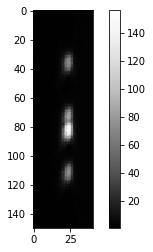

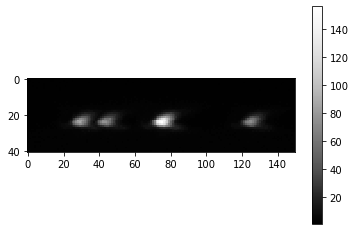

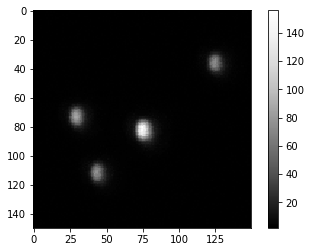

In [3]:
imshow(cle.maximum_x_projection(bead_image), colorbar=True)
imshow(cle.maximum_y_projection(bead_image), colorbar=True)
imshow(cle.maximum_z_projection(bead_image), colorbar=True)

For determining an average PSF, technically we would need to crop out all the individual beads, align them and then average the images.

## Find bead centroids

However, there is a trick to determine the PSF. For that, we simulate a perfect `object` image. For that, we extract the centroids of segmented beads and assume those are the real objects. Afterwards, we deconvolve the `bead_image` with the perfect `object` image to retrieve the PSF. Note: This will only work if there are no other objects in the image and if beads are not too dense.

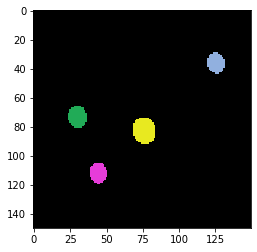

In [4]:
# Segment objects
label_image = cle.voronoi_otsu_labeling(bead_image)
cle.imshow(label_image, labels=True)

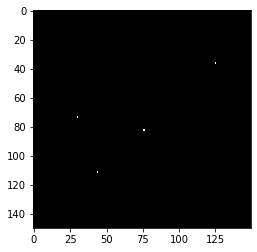

In [5]:
# Determine centroids
labeled_centroids_image = cle.reduce_labels_to_centroids(label_image)

# binarize
object_image = labeled_centroids_image > 0

cle.imshow(object_image)

In [6]:
object_image.min(), object_image.max()

(0.0, 1.0)

In [7]:
iterations = 100

#from skimage import restoration
#psf = restoration.richardson_lucy(bead_image.astype(float), object_image.astype(float), num_iter=iterations)

psf = rl.doRLDeconvolutionFromNpArrays(bead_image.astype(float), 
                                       np.asarray(object_image).astype(float), 
                                       niter=iterations, 
                                       method='gpu', 
                                       resAsUint8=False )

We can then inspect the average PSF in 3D. If the PSF is a bit off-center, this is not a big problem. However, if it touches the image boarde, that can cause problems later on.

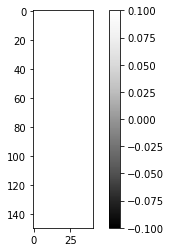

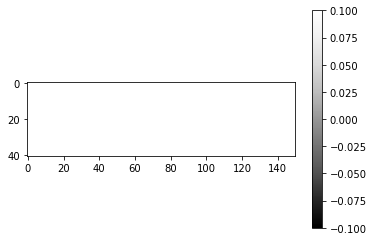

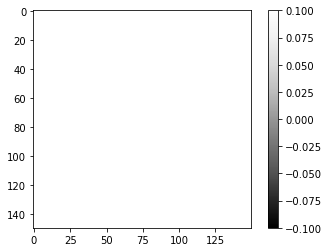

In [8]:
imshow(cle.maximum_x_projection(psf), colorbar=True)
imshow(cle.maximum_y_projection(psf), colorbar=True)
imshow(cle.maximum_z_projection(psf), colorbar=True)

We can crop the PSF by determining its center first and then selecting pixels around it.

In [9]:
center = (np.asarray(psf.shape) / 2).astype(int)
center

array([20, 75, 75])

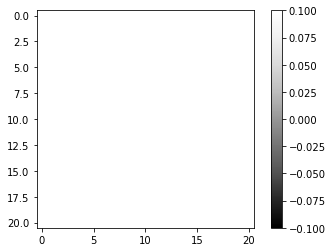

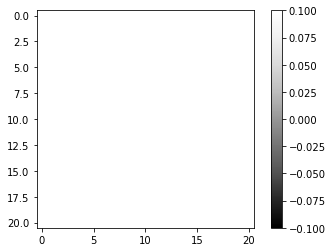

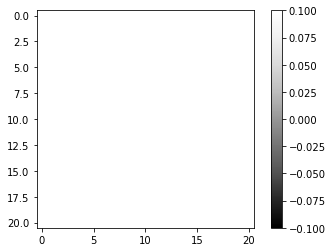

(21, 21, 21)

In [10]:
radius = 10

cropped_psf = psf[center[0]-radius:center[0]+radius+1,
                  center[1]-radius:center[1]+radius+1,
                  center[2]-radius:center[2]+radius+1]

imshow(cle.maximum_x_projection(cropped_psf), colorbar=True)
imshow(cle.maximum_y_projection(cropped_psf), colorbar=True)
imshow(cle.maximum_z_projection(cropped_psf), colorbar=True)
cropped_psf.shape

After we determined a well centered PSF, we can save it for later re-use. Before doing that, we normalize the PSF. Goal is to have an image where the total intensity is `1`. This makes sure that an image that is deconvolvolution using this PSF later on does not modify the image's intensity range.

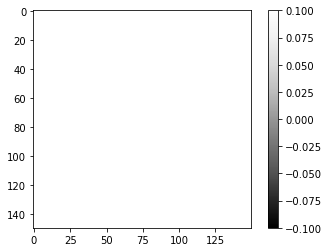

In [11]:
normalized_psf = psf / np.sum(psf)

imshow(normalized_psf, colorbar=True)

In [12]:
imsave('../../data/psf.tif', normalized_psf)